In [47]:
import sys
sys.path.append('../bin/')
from load_data import *
import matplotlib.pyplot as plt
from classification import *
import time

In [48]:
input_data = 'mnist'
num_classes= 10
DATA_SHAPE = 28*28
num_comp   = [50,200,500,DATA_SHAPE]
outpath    = '../outputs/%s/classification/'%input_data
covpath    = '../outputs/%s/covariance_estimator/'%input_data
plotpath   ='../outputs/%s/figures/'%input_data
modes      = ['NERCOME']
masks      = [True,False]

In [49]:
if input_data == 'mnist':
    load_data = load_mnist
if input_data == 'cifar10':
    load_data = load_cifar10

In [50]:
x_train, targets_train, x_test, targets_test = load_data()

In [51]:
def make_plots(x, input_type):

    num = np.int(np.floor(np.sqrt(len(x))))
    if num > 8:
        num = 8
    if input_type=='mnist':
        fig, axes = plt.subplots(num,num,figsize=(num,num))
        plt.set_cmap('gray')
        k =0
        for j in range(num):
            for i in range(num):
                k+=1
                axes[i][j].imshow(x[k].reshape(28,28))
                axes[i][j].axis('off')
        
        plt.show()
        
    elif input_type=='cifar10':
        fig, axes = plt.subplots(num,num,figsize=(num,num))
        k =0
        for j in range(num):
            for i in range(num):
                k+=1
                img = np.swapaxes(np.reshape((x[k]),(32,32,3),'F'),0,1)
                axes[i][j].imshow(img, interpolation='bilinear')
                axes[i][j].axis('off')
        plt.show()
    return True


In [76]:
from sklearn.covariance import LedoitWolf, EmpiricalCovariance, OAS
import scipy.linalg as lg
import numpy.linalg as nlg
from sklearn.decomposition import PCA

def get_covariance(R,var,num):
    '''
    get covarinace estimation for specific number of components
    num: number of components
    R: matrix of eigenvectors
    var: array of eigenvalues
    '''
    fl   = len(var)
    var_ = var[0:num]
    R    = R[0:num]
    
    if num<fl:
        sigma2 = np.mean(var[num::])
    else: 
        sigma2 = 0.

    C_            = np.dot(R.T,np.dot(np.diag(var_), R))+np.eye(len(R.T))*sigma2
    Cinv          = lg.inv(C_)
    sign ,logdetC = nlg.slogdet(C_)
    
    return Cinv, logdetC


class CovarianceEstimator():

    def __init__(self,mode, label, masking):
        
        assert(mode in ['ML','OAS', 'LW','NERCOME'])
        self.mode   = mode
        self.label  = label
        self.masking= masking
    
    def diag_decomp(self):
        # do svd for numerical stability (ensuring var>=0)
        U,s,V     = lg.svd(self.cov)
        indices   = np.argsort(s)[::-1]
        self.vars = s[indices]
        self.R    = V[indices]
        if len(np.where(self.vars==0.)[0])>0:
            print('covariance estimate contains singular eigenvalues')
        #print('svd ratio', np.mean(np.dot(np.dot(self.R.T,np.diag(self.vars)),self.R)/self.cov))
        return True
    
    def pca(self,data, mask_in, mask_out):
        
        data = self._data_prep(data, mask_in,mask_out)
        
        num       = data.shape[1]
        pca       = PCA(svd_solver='full',n_components=num)
        pca.fit(data)
        self.pca_vars= pca.explained_variance_
        self.pca_R   = pca.components_
        #print('pca ratio', np.mean(np.dot(np.dot(self.pca_R.T,np.diag(self.pca_vars)),self.pca_R)/self.cov))
        
    def _data_prep(self,data, mask_in, mask_out):
        
        if len(mask_in)==data.shape[1]:
            self.masking = False
            print('no zero variance pixels in data')
        
        if self.masking:
            data = data[:, mask_in]
        else:
            #inpainting white noise
            data[:,mask_out] = np.random.randn(np.prod(data.shape)).reshape(data.shape)[:,mask_out]*0.1
            
        self.mask_in = mask_in
        self.mask_out= mask_out
        self.mean = np.mean(data, axis=0)
        
        return data
    
    
    def dist(self,cov1,cov2=None):
        if np.any(cov2 == None):
            cov2=self.cov
        A = cov1-cov2
        dist = np.trace(np.dot(A,A.T))
        return dist
    
    
    def nercome_estimator(self,data,splits=None,num_esti=None):

        nn      = len(data)
        ddim    = data.shape[1]
        if splits== None:
            if ddim < 200:
                splits = [0.33,0.4,0.45,0.5,0.55,0.66,0.7,0.75,0.8]
            else:
                splits = [0.66]
        if num_esti== None:
            num_esti  = min(nn//2,100)

        minQs      = -1
        best_split = 0.
        best_esti  = np.zeros((ddim,ddim))
        for split_frac in splits:
            print('nercome estimation with split %.2f, #samples %d'%(split_frac,num_esti))
            split    = np.int(split_frac*nn)
            cov      = np.zeros((ddim,ddim))
            cov_esti = np.zeros((ddim,ddim))
            for ii in range(num_esti):
                np.random.shuffle(data)
                data1 = data[0:split]
                data2 = data[split::]
                cov1     = EmpiricalCovariance().fit(data1).covariance_
                w1,v1    = lg.eigh(cov1)
                del cov1, w1
                cov2     = EmpiricalCovariance().fit(data2).covariance_
                diags    = np.diag(np.dot(np.dot(v1.T,cov2),v1))
                esti     = np.dot(np.dot(v1,np.diag(diags)),v1.T)
                cov+=cov2/num_esti
                del cov2
                cov_esti+=esti/num_esti

            Q = self.dist(cov_esti, cov)
            if minQs==-1 or Q<minQs:
                minQs=Q
                self.best_split = split_frac
                best_esti = cov_esti
        print('best nercome split is %.2f'%self.best_split)
        return best_esti
        

    def fit(self,data, mask_in, mask_out):
        
        data = self._data_prep(data, mask_in,mask_out)
        
        if self.mode =='ML':
            self.cov = EmpiricalCovariance().fit(data).covariance_
        elif self.mode =='OAS':
            self.cov = OAS().fit(data).covariance_
        elif self.mode =='LW':
            self.cov = LedoitWolf().fit(data).covariance_
        elif self.mode =='NERCOME':
            self.cov = self.nercome_estimator(data)
        else: 
            raise ValueError
            
        return True
    
    def compute_logdet(self):
        #numerically unstable 
        sign ,self.logdetC = nlg.slogdet(self.cov)
        return True

    def compute_inverse(self):
        #full thing is often note invertible, use decomposition
        self.Cinv = lg.inv(self.cov)
        return True
    
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        if self.masking:
            self.filename = os.path.join(path,'cov_estimate_%s_%d_masked.pkl'%(self.mode,self.label))
        else:   
            self.filename = os.path.join(path,'cov_estimate_%s_%d.pkl'%(self.mode,self.label))
        
        pkl.dump(self, open(self.filename,'wb'))
        
        return self.filename

In [73]:
def prepare_data(data, labels, num_classes):
    '''
    orderes data by labels and identifies zero variance pixels
    '''
    ordered_data = []
    masks_in     = []
    masks_out    = []
    for ii in range(num_classes):
        ind     = np.where(labels==ii)[0]
        d       = data[ind]
        mask_in = np.where(np.var(d, axis=0)>0.)[0]
        ordered_data+=[d]
        mask_out= np.where(np.var(d, axis=0)==0.)[0]
        masks_in+=[mask_in]
        masks_out+=[mask_out]
    
    return ordered_data, masks_in, masks_out

In [74]:
d_v, mv_in, mv_out = prepare_data(data=x_train,labels=targets_train, num_classes=num_classes)
d_t, mt_in, mt_out = prepare_data(data=x_test,labels=targets_test, num_classes=num_classes)

In [75]:
def estimate_covariances(modes,masks,path):
    for mode in modes:
        for masking in masks:
            for ii, d in enumerate(d_v):
                if masking:
                    filename = os.path.join(path,'cov_estimate_%s_%d_masked.pkl'%(mode,ii))
                else:   
                    filename = os.path.join(path,'cov_estimate_%s_%d.pkl'%(mode,ii)) 
                if not os.path.isfile(filename):
                    cov = CovarianceEstimator(mode=mode,label=ii,masking=masking)
                    cov.fit(d,mv_in[ii],mv_out[ii])
                    cov.diag_decomp()          
                    cov.pca(d,mv_in[ii],mv_out[ii])
                    cov.save(path)
    return True

estimate_covariances(modes,masks,covpath)

nercome estimation with split 0.66, #samples 100
best nercome split is 0.66
nercome estimation with split 0.66, #samples 100
best nercome split is 0.66
nercome estimation with split 0.66, #samples 100
best nercome split is 0.66
nercome estimation with split 0.66, #samples 100
best nercome split is 0.66
nercome estimation with split 0.66, #samples 100
best nercome split is 0.66
nercome estimation with split 0.66, #samples 100
best nercome split is 0.66
nercome estimation with split 0.66, #samples 100
best nercome split is 0.66
nercome estimation with split 0.66, #samples 100
best nercome split is 0.66


True

In [77]:
def get_log_prob(logdet,Cinv,data,mean):
    d    = len(data)
    data = data-mean
    Cinv_d = np.einsum('jk,...k->...j',Cinv,data, optimize=True)
    logprob = -0.5*logdet-0.5*d*np.log((2*np.pi))-0.5*np.einsum('ij,ij->i',data, Cinv_d, optimize=True)
    return logprob

In [78]:
def classify(data,labels,covs, num_classes, num, pca=False):
    acc = []
    nums= []
    for jj in range(num_classes):
        indices = np.where(labels==jj)[0]
        dd      = data[indices]
        logprob = []
        for ii,cov in enumerate(covs):
            if cov.masking:
                d_      = dd[:,cov.mask_in]
            else:
                d_      = np.ones_like(dd)*0.01
                d_[:,cov.mask_in] = dd[:,cov.mask_in]
            if num > d_.shape[1]:
                num = d_.shape[1]
            if pca:
                Cinv, logdetC = get_covariance(cov.pca_R,cov.pca_vars,num)
            else:
                Cinv, logdetC = get_covariance(cov.R,cov.vars,num)
            logprob_= get_log_prob(logdetC,Cinv,d_,cov.mean)
            logprob+=[logprob_]
        acc+=[len(np.where(np.argsort(np.asarray(logprob),axis=0)[-1]==jj)[0])/len(dd)]
    return np.asarray(acc)

In [83]:
def perform_classification(modes, masks, inpath, outpath, pca=True, rerun=False):
    
    outfile = os.path.join(outpath,'results.pkl')
    if os.path.isfile(outfile) and rerun==False:
        results = pkl.load(open(outfile, 'rb'))
    else:
        results = {}
        if pca:
            results['pca']={}
        for mode in modes:
            results[mode] ={}

            for masking in masks:
                if masking:
                    label = 'masked'
                else:
                    label = 'inpainted'
                results[mode][label]={}
                if pca and mode=='ML':
                    results['pca'][label]={}
                covs=[]
                for ii in range(num_classes):
                    if masking:
                        filename = os.path.join(inpath,'cov_estimate_%s_%d_masked.pkl'%(mode,ii))
                    else:   
                        filename = os.path.join(inpath,'cov_estimate_%s_%d.pkl'%(mode,ii))
                    covs+=[pkl.load(open(filename, 'rb'))]
                accs=[]
                nums=[]
                for num in num_comp:
                    print(mode, label, num)
                    acc  = classify(x_test,targets_test,covs, num_classes, num=num)
                    accs+=[acc]
                results[mode][label]['accs']=np.asarray(accs)
                if pca:
                    if mode=='ML':
                        accs=[]
                        for num in num_comp:
                            print('pca', num)
                            acc = classify(x_test,targets_test,covs, num_classes, num=num, pca=True)
                            accs+=[acc]
                        results['pca'][label]['accs']=np.asarray(accs)
                if not os.path.exists(outpath):
                    os.makedirs(outpath)
                #pkl.dump(results, open(outfile, 'wb'))
    return results

resnew = perform_classification(modes,masks, inpath=covpath, outpath=outpath, pca=False, rerun=True)

NERCOME 50
NERCOME 200
NERCOME 500
NERCOME 784
NERCOME 50
NERCOME 200
NERCOME 500
NERCOME 784


In [88]:
results['NERCOME']['inpainted']=resnew['NERCOME']['inpainted']

In [91]:
pkl.load(open(outfile, 'rb'))

{'LW': {'inpainted': {'accs': array([[ 0.99081633,  0.98325991,  0.96027132,  0.94059406,  0.96537678,
            0.9338565 ,  0.96764092,  0.92509728,  0.95277207,  0.94350842],
          [ 0.98061224,  0.96035242,  0.95251938,  0.92673267,  0.96741344,
            0.91479821,  0.95302714,  0.92412451,  0.93223819,  0.9197225 ],
          [ 0.96530612,  0.94096916,  0.95348837,  0.92079208,  0.93686354,
            0.87556054,  0.92797495,  0.90758755,  0.88501027,  0.86025768],
          [ 0.9622449 ,  0.95154185,  0.93992248,  0.92772277,  0.92260692,
            0.86434978,  0.93319415,  0.90661479,  0.86447639,  0.87215064]])},
  'masked': {'accs': array([[ 0.98469388,  0.94889868,  0.98837209,  0.94257426,  0.98167006,
            0.96300448,  0.94989562,  0.93385214,  0.90759754,  0.84737364],
          [ 0.95714286,  0.92422907,  0.98352713,  0.92079208,  0.9592668 ,
            0.91367713,  0.92066806,  0.92898833,  0.81724846,  0.76511397],
          [ 0.95      ,  0.9577092

In [46]:
import matplotlib
def make_acc_figure(modes,labels,results,path,plotname):
    cmap = matplotlib.cm.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
    ls = ['-','--','-.',':',(0, (3, 5, 1, 5, 1, 5)),(0, (3, 1, 1, 1, 1, 1)),(0, (5, 10))]
    markers=['o','^','d','>','*','+']
    plt.figure()
    jj =0
    for mode in modes:
        for label in labels:
            for ii in range(num_classes):
                if ii ==0:
                    plt.plot(num_comp,results[mode][label]['accs'][:,ii],color=cmap(norm(ii)),marker=markers[jj],ls=ls[jj],label='%s, %s'%(mode,label))
                else:
                    plt.plot(num_comp,results[mode][label]['accs'][:,ii],color=cmap(norm(ii)),marker=markers[jj],ls=ls[jj])
            jj+=1
    plt.legend()
    plt.xlabel('# components')
    plt.ylabel('accuracies')
    if not os.path.exists(path):
        os.makedirs(path)
    filename = os.path.join(path,plotname)
    print(filename)
    plt.savefig(filename,bbox_inches='tight')
    plt.show()
    return True

../outputs/mnist/figures/MLvsPCA_masked.png


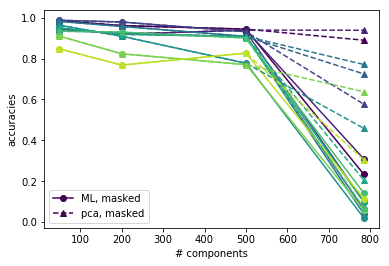

In [42]:
_=make_acc_figure(['ML','pca'],['masked'],results,plotpath, 'MLvsPCA_masked.png')

../outputs/mnist/figures/MLvsPCA_inpainted.png


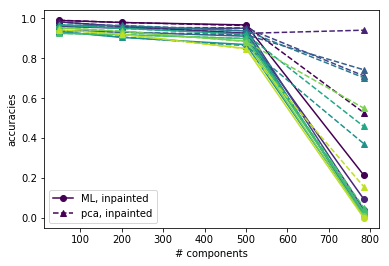

In [43]:
_=make_acc_figure(['ML','pca'],['inpainted'],results,plotpath, 'MLvsPCA_inpainted.png')

../outputs/mnist/figures/MLvsLW_masked.png


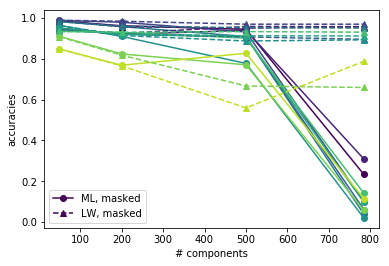

In [40]:
_=make_acc_figure(['ML','LW'],['masked'],results,plotpath, 'MLvsLW_masked.png')

../outputs/mnist/figures/MLvsLW_inpainted.png


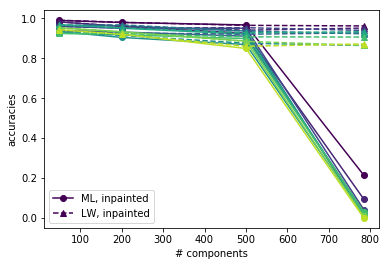

In [41]:
_=make_acc_figure(['ML','LW'],['inpainted'],results,plotpath, 'MLvsLW_inpainted.png')

../outputs/mnist/figures/MLvsLWvsNERCOME_inpainted.png


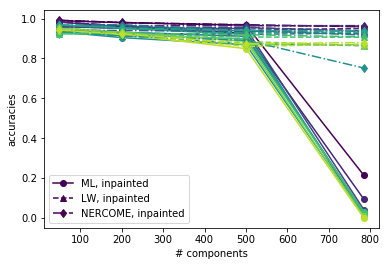

In [92]:
_=make_acc_figure(['ML','LW','NERCOME'],['inpainted'],results,plotpath, 'MLvsLWvsNERCOME_inpainted.png')

../outputs/mnist/figures/MLvsLWvsNERCOME_masked.png


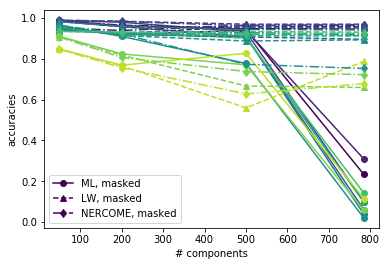

In [93]:
_=make_acc_figure(['ML','LW','NERCOME'],['masked'],results,plotpath, 'MLvsLWvsNERCOME_masked.png')

../outputs/mnist/figures/LWvsNERCOME_inpainted.png


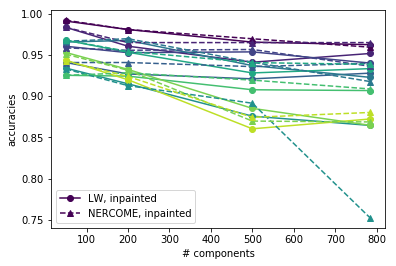

In [94]:
_=make_acc_figure(['LW','NERCOME'],['inpainted'],results,plotpath, 'LWvsNERCOME_inpainted.png')

../outputs/mnist/figures/LWvsNERCOME_masked.png


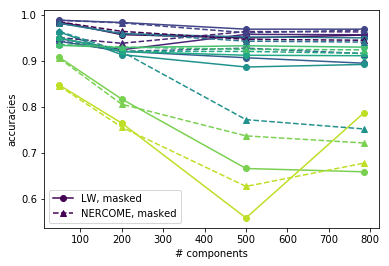

In [95]:
_=make_acc_figure(['LW','NERCOME'],['masked'],results,plotpath, 'LWvsNERCOME_masked.png')